## Data processing and plotting for manuscript: Cave airflow patterns control calcite dissolution rates within a cave stream: Blowing Springs Cave, Arkansas, USA

In [1]:
%pylab inline

#Import from standard scientific computing and plotting packages
import datetime as dt
from pandas import read_csv, read_excel, concat, DataFrame, Series, Timedelta, TimedeltaIndex
from scipy.optimize import curve_fit
from scipy.stats import spearmanr,linregress
import seaborn as sns
#####################################################
#Imports from Olm. A copy of the needed components of Olm is included in this
#repository, so that this code should work without installation of Olm. However,
#an updated version of the Olm package can be found on Github at:
#
#  https://github.com/CovingtonResearchGroup/olm
#####################################################
from olm.loggers.CampbellToolkit import read_dat
from olm.calcite import solutionFromCaPCO2, pwpFromSolution, pwp_to_mm_yr, palmerFromSolution, dissRateFromCaPCO2#Relaxed
from olm.general import mgL_to_molL, CaFromCond, condTo25, CtoK
from olm.USGS.DataRetrieval import GetDailyDischargeRecord



Populating the interactive namespace from numpy and matplotlib


### Read Blowing Springs data and clean up bad values.

In [2]:
######################
## csv file was generated by initial pre-processing script that concatenates data
## from all loggers on site and resamples at hourly frequency.
######################
df = read_csv('Blowing-Springs-master-data-interpolated.csv', parse_dates=True, index_col=0)


##############
#Clean up data
##############

#Fix period where temp was recorded as F (convert to C)
where_f = df.Temp_Baro_outside>40.
df.Temp_Baro_outside[where_f]= (df.Temp_Baro_outside[where_f]-32.)*5./9.
where_f = df.Temp_outside>40.
df.Temp_outside[where_f]= (df.Temp_outside[where_f]-32.)*5./9.
where_f = df.Temp_BS4_Cond>17.
df.Temp_BS4_Cond[where_f] = (df.Temp_BS4_Cond[where_f] - 32.)*(5./9.)


df.CO2_Water['10-13-2015':'11-25-2015'] = np.nan
#Corrected for different sensor, switched from 2% to 10%
df.CO2_Water['11-25-2015':'12-25-2015'] = 5.*df.CO2_Water['11-25-2015':'12-25-2015']
df.CO2_Water['1-1-2016':'2-22-2016'] = np.nan
df.CO2_Water[df.CO2_Water<500./1000000.] = np.nan
df.CO2_Water[df.CO2_Water<300] = np.nan
df.CO2_Air[df.CO2_Air<300] = np.nan

#Correct CO2 for temperature
T_corr = CtoK(15)/CtoK(25)
df.CO2_Air = df.CO2_Air*T_corr
df.CO2_Water = df.CO2_Water*T_corr

#Filter out low conductivity values (which are bad)
df.Cond_BS4_Cond[df.Cond_BS4_Cond<40] = np.nan
#Remove temp low spikes
df.Temp_BS4_Cond[df.Temp_BS4_Cond<10] = np.nan


#Correct cond to 25 C
Cond_temp_corrected = condTo25(df.Cond_BS4_Cond, df.Temp_BS4_Cond)


### Build relationship to estimate discharge

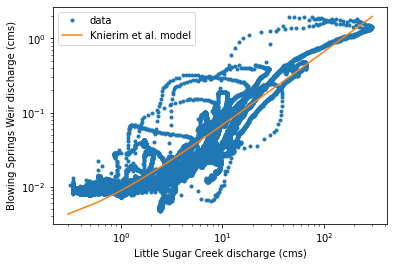

In [3]:
lsc_bs_knierim = read_csv('little-sugar-bs-data.csv', index_col=0, parse_dates=True)
real_date = TimedeltaIndex(lsc_bs_knierim.index.values, unit='d') + dt.datetime(1900,1,1)
lsc_bs_knierim.index = real_date
lsc_q = lsc_bs_knierim['LS, cms']
bs_q_weir = lsc_bs_knierim['BS, cms']
loglog(lsc_q, bs_q_weir, '.')
xplot = linspace(0.3, 300,1000)
bs_model = (xplot*0.0066 + 0.0023)
plot(xplot, bs_model)
xlabel('Little Sugar Creek discharge (cms)')
ylabel('Blowing Springs Weir discharge (cms)')
legend(['data','Knierim et al. model'])

The spring exhibits both a minimum baseflow, as noted by Knierim et al. (2015), and a possible rollover at high discharge. Knierim et al. (2015) also used a minimum constant baseflow discharge. However, here we want a smooth function that represents this behavior, to aid in calculation of correlation coefficients. We use a sigmoid shape, fit to the data in log space to obtain similar % error at different discharges.

In [7]:
print('median discharge=',bs_q_weir.median(), ' m^3/s ')
print('mean discharge=',bs_q_weir.mean(), ' m^3/s ')

median discharge= 0.0100311838  m^3/s 
mean discharge= 0.02961068392137205  m^3/s 


In [ ]:
def sigmoid(q, a, b, c, d):
    return a/(1+exp(-d*(q-b)))+ c

In [ ]:
#Avoid exact duplicate values, which causes problems for curve_fit add very small random noise
log_bs_q = log10(bs_q_weir+ randn(len(bs_q_weir))*0.000001)
log_lsc_q = log10(lsc_q + randn(len(lsc_q))*0.001)
log_q_df = DataFrame({'bs':log_bs_q, 'lsc':log_lsc_q})
#Filter bad data points
log_q_df = log_q_df[log_q_df.bs>-3]
log_q_df = log_q_df[log_q_df.lsc>-1]
#Resample on daily frequency
log_q_df = log_q_df.resample('d').mean()
log_q_df = log_q_df.dropna()
#Fit sigmoid
opt_params, cov = curve_fit(sigmoid, log_q_df.lsc, log_q_df.bs, p0=[2.3, 1.3,-2.1,2.5])
print(opt_params)

In [ ]:
figure()
#plot(log_q_df.lsc, log_q_df.bs, '.')
loglog(10**log_q_df.lsc, 10**log_q_df.bs, '.')
xplot = linspace(-.5,2.5,100)
yplot = sigmoid(xplot, opt_params[0],opt_params[1],opt_params[2],opt_params[3])
plot(10**xplot,10**yplot)
rmse = sqrt(mean((log_q_df.bs - sigmoid(log_q_df.lsc, opt_params[0],opt_params[1],opt_params[2],opt_params[3]))**2))
print('RMSE=',rmse)
xplot = linspace(0.3, 300,1000)
bs_model = (xplot*0.0066 + 0.0023)
plot(xplot, bs_model, '--')

ylabel('Daily BSC discharge (cubic meters per second)')
xlabel('Daily LSC discharge (cubic meters per second)')
legend(['data', 'sigmoid model', 'linear model'])

Q_perc_err = (10**rmse - 1)
print('Q% err=',Q_perc_err)
savefig('Fig2.pdf')

### Read in USGS discharge data and estimate Blowing Springs discharge

In [ ]:
######
## Commented out code automatically retrives data from USGS NWIS. 
## Here is it saved as .csv, so this isn't needed anymore.
#####
#sc = GetDailyDischargeRecord('07188838', str(df.index[0])[:10], str(df.index[-1])[:10])
#sc.to_csv('Little-Sugar-Creek-discharge.csv')

sc = read_csv('Little-Sugar-Creek-discharge.csv', index_col=0, parse_dates=True)
cms_per_cfs = 0.0283
cms_to_ls = 1000.
#Estimate Blowing Springs discharge based on relationship from Knierim et al. (2015)
#bs_q_est = (sc.discharge*cms_per_cfs*0.0066 + 0.0023) * cms_to_ls
bs_q_est = cms_to_ls*10**sigmoid(log10(sc.discharge*cms_per_cfs), opt_params[0],opt_params[1],opt_params[2],opt_params[3])

### Plot SpC vs. Q and fit polynomial (Fig 4)

In [ ]:
#Resample SpC on daily frequency
qspc = DataFrame({'q':bs_q_est.values, 'cond':Cond_temp_corrected.resample('d').mean().values}, index=bs_q_est.index)
#Get rid of NaNs (missing data)
qspc = qspc.dropna()
#Fit polynomial
pmod, residuals, rank, singular_values, rcond = polyfit(log10(qspc.q), qspc.cond,3, full=True)
pfit = poly1d(pmod)
print ("Polynomial coeffs. from high to low order:",pmod)

RMSE = sqrt(residuals/len(qspc.q))[0]
print("RMSE = ",str(RMSE)[:4])

figure()
semilogx(qspc.q,qspc.cond,'o',color='grey')
xfit = linspace(1,3,100)
plot(10**xfit,pfit(xfit),'k-', lw=1.5)
xlabel('Discharge (liters per second)')
ylabel('SpC (microsiemens per centimeter)')
ax = gca()
text(0.67,0.9, 'RMSE='+str(RMSE)[:4]+r' ${\rm \mu S/cm}$',transform=ax.transAxes, fontsize=12)
tight_layout()
savefig('Fig4.pdf')

print("number of points = ",len(qspc))
cond_binned_err = []
q_percentiles = [0]
for n in arange(1,21):
    pn = percentile(qspc.q,n*5)
    q_percentiles.append(pn)
    #plot([pn,pn],[75,275], '--')
    conds_in_bin = qspc.cond[logical_and(qspc.q<pn,qspc.q>q_percentiles[-2])]
    cond_binned_err.append(std(conds_in_bin))
q_percentiles[-1] = 5*10**3
cond_binned_err = array(cond_binned_err)
q_percentiles = array(q_percentiles)

### Binned errors

In [ ]:
semilogx(q_percentiles[1:],cond_binned_err)
xlabel('Discharge (liters per second)')
ylabel('Std of conductivities in bin (microS/cm)')

### Create total time series plot (Fig 3)

In [ ]:
##Figure 2
figure(figsize=(8,11))
subplot(4,1,1)
df.CO2_Air.plot(color='black')
df.CO2_Water.plot(color='gray')
ylim([0,6000])
legend([r'${\rm CO_2}$ Air',r'${\rm CO_2}$ Water'],fontsize=8)
ax = gca()
text(0.96,0.9, '(a)',fontsize=12, transform=ax.transAxes)
ylabel(r'${\rm CO_2}$ (parts per million)')

subplot(4,1,2)
df.WindVelDir.plot(color='k')
ylabel('Airflow velocity\n (meter per second)')
ax = gca()
text(0.96,0.9, '(b)',fontsize=12, transform=ax.transAxes)
  
subplot(4,1,3)
Cond_temp_corrected.plot(color='k')
#Create estimated SpC timeseries
cond_est = DataFrame({'cond_est':pfit(log10(bs_q_est.values))}, index=bs_q_est.index)
cond_est.cond_est.plot(color='grey', alpha=0.5)
legend(['Measured','Estimated'],fontsize=8)
ylabel('SpC\n (microsiemens per centimeter)')
ylim([50,300])
ax = gca()
text(0.96,0.9, '(c)',fontsize=12, transform=ax.transAxes)


subplot(4,1,4)
bs_q_est.plot(color='k',logy=True)
ylabel('Estimated Discharge\n (liters per second)', fontsize=10)
ax = gca()
text(0.96,0.9, '(d)',fontsize=12, transform=ax.transAxes)


tight_layout()
savefig('Fig3.pdf')


### When does the cave experience updraft and downdraft?

In [ ]:
df_2d = df.resample('3d').mean()
plot(df_2d.index.dayofyear, df_2d.WindVelDir, 'o')

ylabel('Airflow velocity\n (meter per second)')
ax = gca()
text(0.96,0.9, '(b)',fontsize=12, transform=ax.transAxes)
xlabel('Day of the year') 

### Stable cave temp

In [ ]:
df.Temp_t2['11-1-2014':'1-1-2015'].plot()
ylabel('Temperature (C)')
ylim([14.8,15.5])
T_cave= df.Temp_t2['12-8-2014':'12-22-2014'].mean()
print('Stable cave temp = ',T_cave)

### Chimney effect airflow (Fig 5)

In [ ]:
#Fig 4
temp_diff = df.Temp_Baro_outside - T_cave

#Get rid of missing values for fit.
tmp_df = DataFrame({'diff':temp_diff.values,'wind':df.WindVelDir.values })
tmp_df = tmp_df.dropna()

#Define fitting function for chimney effect airflow
def chmny(diff, R):
    return sign(diff)*R*abs(diff)**0.5

#Find best fit
R_opt, p_cov = curve_fit(chmny, tmp_df['diff'].values[0:-1:5], tmp_df['wind'].values[0:-1:5], p0=1.1)
print ("R_opt=",R_opt)
figure()
#Plot temp diff vs. wind vel
scatter(temp_diff[0:-1:5], df.WindVelDir[0:-1:5], marker='.',color='grey')
xfit = linspace(-30,20, 500)
####
# best-fit value is R_opt=0.157
# However, this seems strongly influenced by scatter at positive Windvel.
# Least-squares fitting strongly penalizes outliers.
# Adjusted this to 0.18 to better fit the densest part of the data.
####
R_plot=0.18
yfit = chmny(xfit, R_plot)
plot(xfit,yfit, color='k', lw=1.5)
xlabel('Outside temp - Cave temp (Celsius)')
ylabel('Cave airflow velocity\n(meters per second)')
tight_layout()
savefig('Fig5.pdf')

#Using value of
f=0.05
T_ext = 15.+273.
L=1000.
deltah = 25
g=9.8
print ("approximated diameter =",R_plot**2*f*L*T_ext/(2.*g*deltah))



### Zoomed figure of CO2-airflow interactions (Fig 7)

In [ ]:
CO2_Water = df.CO2_Water
CO2_Air = df.CO2_Air
wv = df.WindVelDir
fig1, ax1 = subplots()
lns1 = CO2_Air.plot(axes=ax1, lw=2, color='C1')
lns2 = CO2_Water.plot(axes=ax1, lw=2, color='C0')
ax1.set_ylabel(r'${\rm CO_2}$ (parts per million)', fontsize=15)
ax1.set_ylim([0,6000])
ax1.set_xlim(['9/17/2014', '10/8/2014'])

ax2 = ax1.twinx()
lns3 = wv.plot(axes=ax2, lw=1, color='black')
legend(ax1.lines+ax2.lines, ['Air', 'Water','Air Vel.'])
ax2.fill_between(df.index,0, wv, where=(wv<=0), color='red', alpha=.5)
ax2.plot([391920.0, 392424.0],[0,0], '--', color='grey',lw=3)
ax2.get_xlim()
ax2.set_ylim([-3.,0.75])
ax2.set_ylabel('Cave airflow velocity (m/s)', fontsize=15)
ax2.set_xlim(['9/17/2014', '10/8/2014'])
tight_layout()

savefig('Fig7.pdf')#Wind-direction-and-CO2.png')
#show()

In [ ]:
#############
### Read Ca-SpC data from Kneirim et al. (2017)
#############
kd = read_csv('Knierim-BS-Water-Chem-Data.csv', na_values=-9999)

In [ ]:
### Clean out bad values
good_ids = kd.Flag != 'E'
good_ids = logical_and(good_ids, ~kd.SpecCond.isnull()) 
good_ids = logical_and(good_ids, ~kd.Ca.isnull())
kdspc = kd.SpecCond[good_ids]
kdCa = kd.Ca[good_ids]
#Regress Ca vs. SpC 
m, b, r, p, err = linregress(kdspc,kdCa)
figure()
#Plot points and regression
plot(kdspc,kdCa, 'o')
plot(kdspc.values, m*kdspc.values +b, '-')
#Global relationship from Krawczyk and Ford (2006)
plot(kdspc.values, 0.4*(kdspc.values -31.5)/1.86, '-')
xlabel('SpC ($\mu$S/cm)')
ylabel('[Ca] mg/l')

print('m=',m)
print('b=', b)
print('rmse=',sqrt(mean(((kdCa - m*kdspc.values - b))**2.)))
print('rmspe=',sqrt(mean(((kdCa - m*kdspc.values - b)/kdCa)**2.)))
print('mean error =',mean((kdCa - m*kdspc.values - b)/kdCa))
print('n=',len(kdCa))

p25 = percentile(kdspc.values,25)
p50 = percentile(kdspc.values,50)
p75 = percentile(kdspc.values,75)


plot([p25,p25],[10,55],'--k')
plot([p50,p50],[10,55],'--k')
plot([p75,p75],[10,55],'--k')

legend(['Data','Fit','Krawczyk + Ford', 'Quartiles'])

spc_q1 = kdspc.values[kdspc.values<p25]
Ca_q1 = kdCa[kdspc.values<p25]
spc_q2 = kdspc.values[logical_and(kdspc.values<p50,kdspc.values>=p25)]
Ca_q2 = kdCa[logical_and(kdspc.values<p50,kdspc.values>=p25)]
spc_q3 = kdspc.values[logical_and(kdspc.values<p75,kdspc.values>=p50)]
Ca_q3 = kdCa[logical_and(kdspc.values<p75,kdspc.values>=p50)]
spc_q4 = kdspc.values[kdspc.values>=p75]
Ca_q4 = kdCa[kdspc.values>=p75]

rmspe_q1 =sqrt(mean(((Ca_q1 - m*spc_q1 - b)/Ca_q1)**2.))
rmspe_q2 =sqrt(mean(((Ca_q2 - m*spc_q2 - b)/Ca_q2)**2.))
rmspe_q3 =sqrt(mean(((Ca_q3 - m*spc_q3 - b)/Ca_q3)**2.))
rmspe_q4 =sqrt(mean(((Ca_q4 - m*spc_q4 - b)/Ca_q4)**2.))

print('rmspe q1 =',rmspe_q1)
print('rmspe q2 =',rmspe_q2)
print('rmspe q3 =',rmspe_q3)
print('rmspe q4 =',rmspe_q4)


### Fill cond time series and calculate errors

In [ ]:
daily_cond = Cond_temp_corrected.resample('d').mean()
missing_cond_dates = daily_cond.isna()
daily_cond[missing_cond_dates] = cond_est.cond_est[missing_cond_dates]
#Error on HOBO conductivity logger 3% or 5 microS/cm
daily_cond_err = daily_cond*0.03
daily_cond_err[daily_cond_err<5.] = 5.
#Calculate additional error as a result of estimation from Q
for day in daily_cond.index[missing_cond_dates]:
    q_day = bs_q_est[day]
    #Get daily error from uncertainty in Q percentile bins
    daily_cond_err[day] = cond_binned_err[logical_and(q_day<=q_percentiles[1:],q_day>q_percentiles[:-1])][0]
daily_cond_err.plot()
ylabel('Error in conductivity (microS/cm)')


In [ ]:
#Create estimated Ca time series from fit above
Ca_mg_L = m*daily_cond + b
#Ca = A(m*cond + b), where A=1+/-rmspe and cond has associated error
dCa_dA = m*daily_cond + b
dCa_dcond = 1.*m
q1_ids = daily_cond<p25
q2_ids = logical_and(daily_cond>=p25,daily_cond<p50)
q3_ids = logical_and(daily_cond>=p50,daily_cond<p75)
q4_ids = daily_cond>=p75
A_err = zeros(len(daily_cond))
A_err[q1_ids] = rmspe_q1
A_err[q2_ids] = rmspe_q2
A_err[q3_ids] = rmspe_q3
A_err[q4_ids] = rmspe_q4
#A_err = 0.1

Ca_mg_L_err = sqrt( (dCa_dA*A_err)**2 + (dCa_dcond*daily_cond_err)**2 )

Ca_mg_L_err.plot()
ylabel('Ca Error [mg/L]')
err_1 = dCa_dA*A_err
err_2 = dCa_dcond*daily_cond_err
err_1.plot()
err_2.plot()
legend(['Total Err','Ca-cond Err', 'Cond-Q Err'], loc='upper left')
print("Most of error comes from error in Ca-cond relation")

#Convert to mol/L
Ca = mgL_to_molL(Ca_mg_L,'Ca')
Ca_err = mgL_to_molL(Ca_mg_L_err, 'Ca')

###  Calculate daily dissolution rates

In [ ]:
ppm_per_atm = 1e6
#Resample Ca and dissolve CO2 on daily frequency
diss_data = DataFrame({'Ca':Ca,'Ca_err':Ca_err,'CO2':df.CO2_Water.resample('d').mean()/ppm_per_atm})
diss_data = diss_data.dropna()#get rid of rows with missing data


diss_rate_pwp, diss_rate_pwp_err = dissRateFromCaPCO2(diss_data.Ca, 
                                   diss_data.CO2, 
                                   [15.]*len(diss_data.index),
                                   method = 'PWP',
                                   error = True,
                                   Ca_err = diss_data.Ca_err/diss_data.Ca,
                                   PCO2_err = 0.03,
                                   molL = True,
                                   error_num = 100,
                                   per_tol=0.001,
                                   return_samples=True,                                                                      
                                      )
########
## This will create some warnings, as some PCO2 values are out of range of Palmer's table
########
diss_rate_palmer, diss_rate_palmer_err = dissRateFromCaPCO2(diss_data.Ca, 
                                   diss_data.CO2, 
                                   [15.]*len(diss_data.index),
                                   method = 'Palmer',
                                   impure = True,
                                   error = True,
                                   Ca_err = diss_data.Ca_err/diss_data.Ca,
                                   PCO2_err = 0.03,
                                   molL = True,
                                   error_num = 100,
                                   per_tol=0.001,
                                   return_samples=True,
                                      )
pwp_desc = diss_rate_pwp_err.apply(DataFrame.describe, axis=1, percentiles=[0.1,.5,.9] )

palmer_desc = diss_rate_palmer_err.apply(DataFrame.describe, axis=1, percentiles=[0.1,.5,.9] )


#Concatenate all dissolution rate data and data used to calculate rates
diss_data = concat({'pwp':diss_rate_pwp, 
                    'pwp_lower':pwp_desc['10%'],
                    'pwp_upper':pwp_desc['90%'], 
                    'palmer':diss_rate_palmer, 
                    'palmer_lower':palmer_desc['10%'],
                    'palmer_upper':palmer_desc['90%'], 
                    'Ca':Ca,
                    'CO2':df.CO2_Water.resample('d').mean()/ppm_per_atm
                   }, axis=1)

In [ ]:
pwp_desc = diss_rate_pwp_err.apply(DataFrame.describe, axis=1, percentiles=[0.05,.5,.95] )

palmer_desc = diss_rate_palmer_err.apply(DataFrame.describe, axis=1, percentiles=[0.05,.5,.95] )


#Concatenate all dissolution rate data and data used to calculate rates
diss_data = concat({'pwp':diss_rate_pwp, 
                    'pwp_lower':pwp_desc['5%'],
                    'pwp_upper':pwp_desc['95%'], 
                    'palmer':diss_rate_palmer, 
                    'palmer_lower':palmer_desc['5%'],
                    'palmer_upper':palmer_desc['95%'], 
                    'Ca':Ca,
                    'CO2':df.CO2_Water.resample('d').mean()/ppm_per_atm
                   }, axis=1)

In [ ]:
pwp_desc = diss_rate_pwp_err.apply(DataFrame.describe, axis=1, percentiles=[0.158,.5,1-0.158] )

palmer_desc = diss_rate_palmer_err.apply(DataFrame.describe, axis=1, percentiles=[0.158,.5,1-0.158] )


#Concatenate all dissolution rate data and data used to calculate rates
diss_data = concat({'pwp':diss_rate_pwp, 
                    'pwp_lower':pwp_desc['15.8%'],
                    'pwp_upper':pwp_desc['84.2%'], 
                    'palmer':diss_rate_palmer, 
                    'palmer_lower':palmer_desc['15.8%'],
                    'palmer_upper':palmer_desc['84.2%'], 
                    'Ca':Ca,
                    'CO2':df.CO2_Water.resample('d').mean()/ppm_per_atm
                   }, axis=1)

### Plot dissolution rate time series (Fig 9)

In [ ]:
figure()
end_date = '11-1-2017' #Data mostly missing beyond this date
diss_data.pwp[:end_date].plot(color='C0',lw=1)
diss_data.palmer[:end_date].plot(color='C1',lw=1)
fill_between(diss_data[:end_date].index, 
             diss_data[:end_date].pwp_upper, 
             diss_data[:end_date].pwp_lower, 
             facecolor='C0', 
             alpha=0.5, 
             interpolate=False)
fill_between(diss_data[:end_date].index, 
             diss_data[:end_date].palmer_upper, 
             diss_data[:end_date].palmer_lower, 
             facecolor='C1', 
             alpha=0.5, 
             interpolate=False)

legend(['PWP','Palmer'], loc='upper right')
ylabel('Dissolution rate\n(millimeters per year)')
tight_layout()
savefig('Fig9.pdf')


### Calculate daily, weekly, and monthly averages of dissolution and possible controls

In [ ]:
# Set period for analysis of dissolution rate variation and controls
start_date = '10-1-2014'
end_date = '1-1-2018'

#Average relevant variables on daily frequency
period = 'd'
smoothed_dissolution = diss_data.pwp[start_date:end_date].resample(period).mean()
smoothed_diss_err_upper = (diss_data[start_date:end_date].pwp_upper - diss_data[start_date:end_date].pwp).resample(period).mean()
smoothed_diss_err_lower = (diss_data[start_date:end_date].pwp - diss_data[start_date:end_date].pwp_lower).resample(period).mean()
smoothed_palmer = diss_data.palmer[start_date:end_date].resample(period).mean()
smoothed_pwp_samples = diss_rate_pwp_err[start_date:end_date].resample(period).mean()
smoothed_cond = df.Cond_BS4_Cond[start_date:end_date].resample(period).mean()
smoothed_CO2 = df.CO2_Water[start_date:end_date].resample(period).mean()
smoothed_airv = df.WindVelDir[start_date:end_date].resample(period).mean()
smoothed_air_CO2 = df.CO2_Air[start_date:end_date].resample(period).mean()
smoothed_discharge = bs_q_est[start_date:end_date].resample(period).mean()

#Create DataFrame of daily averaged values
dr_ot_day = DataFrame({'diss':smoothed_dissolution, 
                       'diss_err_upper':smoothed_diss_err_upper,
                       'diss_err_lower':smoothed_diss_err_lower,
                       'palmer':smoothed_palmer,
                   'CO2':smoothed_CO2, 
                   'cond':smoothed_cond,
                   'airv':smoothed_airv,
                  'CO2_air':smoothed_air_CO2,
                      'discharge':smoothed_discharge})

dr_ot_day = concat((dr_ot_day,smoothed_pwp_samples), axis=1)

#Drop NaNs
dr_ot_day = dr_ot_day.dropna()


#Average values over weekly frequency
period = '7d'
smoothed_dissolution = smoothed_dissolution[start_date:end_date].resample(period).mean()
upper_squared = (diss_data[start_date:end_date].pwp_upper - diss_data[start_date:end_date].pwp)**2.
smoothed_diss_err_upper = sqrt(upper_squared.resample(period).sum())/7.
lower_squared = (diss_data[start_date:end_date].pwp - diss_data[start_date:end_date].pwp_lower)**2.
smoothed_diss_err_lower = sqrt(lower_squared.resample(period).sum())/7.
smoothed_pwp_samples = diss_rate_pwp_err[start_date:end_date].resample(period).mean()
smoothed_palmer = diss_data.palmer[start_date:end_date].resample(period).mean()
smoothed_cond = smoothed_cond[start_date:end_date].resample(period).mean()
smoothed_CO2 = smoothed_CO2[start_date:end_date].resample(period).mean()
smoothed_airv = smoothed_airv[start_date:end_date].resample(period).mean()
smoothed_air_CO2 = smoothed_air_CO2[start_date:end_date].resample(period).mean()
smoothed_discharge = bs_q_est[start_date:end_date].resample(period).mean()

#Store weekly averaged values in DataFrame
dr_ot_week = DataFrame({'diss':smoothed_dissolution,
                        'diss_err_upper':smoothed_diss_err_upper,
                       'diss_err_lower':smoothed_diss_err_lower,
                        'palmer':smoothed_palmer,
                   'CO2':smoothed_CO2, 
                   'cond':smoothed_cond,
                   'airv':smoothed_airv,
                  'CO2_air':smoothed_air_CO2,
                      'discharge':smoothed_discharge})
dr_ot_week = concat((dr_ot_week,smoothed_pwp_samples), axis=1)

dr_ot_week = dr_ot_week.dropna()

#monthly averages of values
period = '30d'
smoothed_dissolution = smoothed_dissolution[start_date:end_date].resample(period).mean()
upper_squared = (diss_data[start_date:end_date].pwp_upper - diss_data[start_date:end_date].pwp)**2.
smoothed_diss_err_upper = sqrt(upper_squared.resample(period).sum())/30.
lower_squared = (diss_data[start_date:end_date].pwp - diss_data[start_date:end_date].pwp_lower)**2.
smoothed_diss_err_lower = sqrt(lower_squared.resample(period).sum())/30.
smoothed_pwp_samples = diss_rate_pwp_err[start_date:end_date].resample(period).mean()
smoothed_palmer = diss_data.palmer[start_date:end_date].resample(period).mean()
smoothed_cond = smoothed_cond[start_date:end_date].resample(period).mean()
smoothed_CO2 = smoothed_CO2[start_date:end_date].resample(period).mean()
smoothed_airv = smoothed_airv[start_date:end_date].resample(period).mean()
smoothed_air_CO2 = smoothed_air_CO2[start_date:end_date].resample(period).mean()
smoothed_discharge = bs_q_est[start_date:end_date].resample(period).mean()

#Store monthly averages in DataFrame
dr_ot_month = DataFrame({'diss':smoothed_dissolution, 
                         'palmer':smoothed_palmer,
                        'diss_err_upper':smoothed_diss_err_upper,
                       'diss_err_lower':smoothed_diss_err_lower,
                   'CO2':smoothed_CO2, 
                   'cond':smoothed_cond,
                   'airv':smoothed_airv,
                  'CO2_air':smoothed_air_CO2,
                      'discharge':smoothed_discharge})
dr_ot_month = concat((dr_ot_month,smoothed_pwp_samples), axis=1)

dr_ot_month = dr_ot_month.dropna()



### Plot relationships between CO2 and airflow (Fig 8)

In [ ]:

figure(figsize=(10,9))
subplot(2,2,1)
plot(dr_ot_day.airv, dr_ot_day.CO2_air, 'ok')
text(-.75,3500, r"$\rho=$"+str(spearmanr(dr_ot_day.airv, dr_ot_day.CO2_air)[0])[:4], fontsize=16, color='k')
plot([0,0],[0,4000],'--',color='grey')
xlabel('Daily mean airflow velocity (meters/sec)', fontsize=14)
ylabel(r'Daily mean cave air ${\rm CO_2}$ (ppm)', fontsize=14)
title('Air', fontsize=18)
xlim([-.9,.6])
ylim([0,4000])

subplot(2,2,2)
plot(dr_ot_week.airv, dr_ot_week.CO2_air, 'ok')
plot([0,0],[0,4000],'--',color='grey')
text(-.75,3500, r"$\rho=$"+str(spearmanr(dr_ot_week.airv, dr_ot_week.CO2_air)[0])[:4], fontsize=16, color='k')
xlabel('Weekly mean airflow velocity (meters/sec)', fontsize=14)
ylabel(r'Weekly mean cave air ${\rm CO_2}$ (ppm)', fontsize=14)
title('Air', fontsize=18)
xlim([-.9,.6])
ylim([0,4000])


subplot(2,2,3)
plot(dr_ot_day.airv, dr_ot_day.CO2, 'ok')
xlabel('Daily mean airflow velocity (meters/sec)', fontsize=14)
ylabel(r'Daily mean dissolved ${\rm CO_2}$ (ppm)', fontsize=14)
text(-.75,5200, r"$\rho=$"+str(spearmanr(dr_ot_day.airv, dr_ot_day.CO2)[0])[:4], fontsize=16, color='k')
title('Water', fontsize=18)
xlim([-.9,.6])
ylim([0,6000])


subplot(2,2,4)
plot(dr_ot_week.airv, dr_ot_week.CO2, 'ok')
title('Water', fontsize=18)
xlabel('Weekly mean airflow velocity (meters/sec)', fontsize=14)
ylabel(r'Weekly mean dissolved ${\rm CO_2}$ (ppm)', fontsize=14)
text(-.75,5200, r"$\rho=$"+str(spearmanr(dr_ot_week.airv, dr_ot_week.CO2)[0])[:4], fontsize=16, color='k')
xlim([-.9,.6])
ylim([0,6000])

tight_layout()
savefig('Fig8.pdf')

### Chemical controls of dissolution rate variation (Fig 10)

In [ ]:
figure(figsize=(5,7))
subplot(2,1,1)
errorbar(dr_ot_day.CO2, dr_ot_day.diss, 
         elinewidth=0.5, 
         fmt='none',
         yerr=(dr_ot_day.diss_err_lower, dr_ot_day.diss_err_upper),
         ecolor='gray', 
         zorder=0)
scatter(dr_ot_day.CO2, dr_ot_day.diss, c=dr_ot_day.cond,zorder=10,s=20)
xlabel(r'Daily ${\rm CO_2}$ (ppm)')
ylabel('Daily dissolution rate (millimeters/year)')
rho,p = spearmanr(dr_ot_day.CO2, dr_ot_day.diss)
text(4200,-.85,r'$\rho=$'+str(rho)[0:4], fontsize=12)
ax = gca()
text(0.035,0.89,'(a)', transform=ax.transAxes, fontsize=14)
cb = colorbar()
cb.set_label(r'SpC (${\rm \mu S/cm})$')
print(rho,p)


subplot(2,1,2)
errorbar(dr_ot_day.cond, dr_ot_day.diss, 
         elinewidth=0.5, 
         fmt='none',
         yerr=(dr_ot_day.diss_err_lower, dr_ot_day.diss_err_upper),
         ecolor='gray', 
         zorder=0)
scatter(dr_ot_day.cond, dr_ot_day.diss, c=dr_ot_day.CO2, zorder=10,s=20)
xlabel('Daily SpC ($\mu$S/cm)')
ylabel('Daily dissolution rate (millimeters/year)')
rho,p=spearmanr(dr_ot_day.cond, dr_ot_day.diss)
text(85,-.85,r'$\rho=$'+str(rho)[0:5], fontsize=12)
xlim([75.,225.])
ax = gca()
text(0.035,0.89,'(b)', transform=ax.transAxes, fontsize=14)
cb = colorbar()
cb.set_label(r'${\rm CO_2}$ (ppm)')
print(rho,p)
tight_layout()
savefig('Fig10.pdf')

### Physical drivers of dissolution rate variation (Fig 11)

In [ ]:
#Get max and min values for ranges on colorbars
qmax = max(dr_ot_day.discharge)
qmin = min(dr_ot_day.discharge)
airvmax = max(dr_ot_day.airv)
airvmin = min(dr_ot_day.airv)


figure(figsize=(8,9))

let_x=0.05
let_y=0.89

subplot(3,2,1)
scatter(dr_ot_day.airv, dr_ot_day.diss, c=dr_ot_day.discharge, s=20, vmin=qmin, vmax=qmax,norm=matplotlib.colors.LogNorm(), zorder=10)
errorbar(dr_ot_day.airv, dr_ot_day.diss, 
         elinewidth=0.75, 
         fmt='none',
         yerr=(dr_ot_day.diss_err_lower, dr_ot_day.diss_err_upper),
         ecolor='gray', 
         zorder=0)
xlim([-1,.6])
ylim([-1.5,1.5])
title('Air flow',fontsize=18)
text(.0,-1.1, r"$\rho=$"+str(spearmanr(dr_ot_day.airv, dr_ot_day.diss)[0])[:4], fontsize=12)
xlabel('Daily airflow velocity (m/s)')
ylabel('Daily dissolution rate (mm/yr)')
ax = gca()
text(let_x,let_y,'(a)', transform=ax.transAxes, fontsize=14)
cb = colorbar()
cb.set_label('Discharge (L/s)')
print(spearmanr(dr_ot_day.airv, dr_ot_day.diss))


subplot(3,2,3)
scatter(dr_ot_week.airv, dr_ot_week.diss, c=dr_ot_week.discharge, s=20, vmin=qmin, vmax=qmax,norm=matplotlib.colors.LogNorm())
errorbar(dr_ot_week.airv, dr_ot_week.diss, 
         elinewidth=0.75, 
         fmt='none',
         yerr=(dr_ot_week.diss_err_lower, dr_ot_week.diss_err_upper),
         ecolor='gray', 
         zorder=0)
xlim([-1,.6])
ylim([-1.5,1.5])
text(.0,-1.1, r"$\rho=$"+str(spearmanr(dr_ot_week.airv, dr_ot_week.diss)[0])[:4], fontsize=12)
cb = colorbar()
cb.set_label('Discharge (L/s)')
xlabel('Weekly airflow velocity (m/s)')
ylabel('Weekly dissolution rate (mm/yr)')
ax = gca()
text(let_x,let_y,'(c)', transform=ax.transAxes, fontsize=14)
print(spearmanr(dr_ot_week.airv, dr_ot_week.diss))

subplot(3,2,5)
scatter(dr_ot_month.airv, dr_ot_month.diss, c=dr_ot_month.discharge, s=20, vmin=qmin, vmax=qmax,norm=matplotlib.colors.LogNorm())
errorbar(dr_ot_month.airv, dr_ot_month.diss, 
         elinewidth=0.75, 
         fmt='none',
         yerr=(dr_ot_month.diss_err_lower, dr_ot_month.diss_err_upper),
         ecolor='gray', 
         zorder=0)

text(.0,-1.1, r"$\rho=$"+str(spearmanr(dr_ot_month.airv, dr_ot_month.diss)[0])[:4], fontsize=12)
xlim([-1,.6])
ylim([-1.5,1.5])
xlabel('Monthly airflow velocity (m/s)')
ylabel('Monthly dissolution rate (mm/yr)')
cb = colorbar()
cb.set_label('Discharge (L/s)')
ax = gca()
text(let_x,let_y,'(e)', transform=ax.transAxes, fontsize=14)
print(spearmanr(dr_ot_month.airv, dr_ot_month.diss))

subplot(3,2,2)
scatter(dr_ot_day.discharge, dr_ot_day.diss, c=dr_ot_day.airv, vmax = airvmax, vmin=airvmin, zorder=10,s=20)
errorbar(dr_ot_day.discharge, dr_ot_day.diss, 
         elinewidth=0.75, 
         fmt='none',
         xerr = dr_ot_day.discharge*Q_perc_err,
         yerr=(dr_ot_day.diss_err_lower, dr_ot_day.diss_err_upper),
         ecolor='gray', 
         zorder=0)

text(90,-1.1, r"$\rho=$"+str(spearmanr(dr_ot_day.discharge, dr_ot_day.diss)[0])[:4], fontsize=12)
ax = gca()
ax.set_xscale('log')
xlim([7,1000])
ylim([-1.5,1.5])
title('Water flow',fontsize=18)
xlabel('Daily discharge (L/s)')
ylabel('Daily dissolution rate (mm/yr)')
cb = colorbar()
cb.set_label('Air flow velocity (m/s)')
ax = gca()
text(let_x,let_y,'(b)', transform=ax.transAxes, fontsize=14)
print(spearmanr(dr_ot_day.discharge, dr_ot_day.diss))


subplot(3,2,4)
scatter(dr_ot_week.discharge, dr_ot_week.diss, c=dr_ot_week.airv, vmax = airvmax, vmin=airvmin,s=20)
errorbar(dr_ot_week.discharge, dr_ot_week.diss, 
         elinewidth=0.75, 
         fmt='none',
         xerr = dr_ot_week.discharge*Q_perc_err,
         yerr=(dr_ot_week.diss_err_lower, dr_ot_week.diss_err_upper),
         ecolor='gray', 
         zorder=0)

text(90,-1.1, r"$\rho=$"+str(spearmanr(dr_ot_week.discharge, dr_ot_week.diss)[0])[:4], fontsize=12)
xlim([7,1000])
ax = gca()
ax.set_xscale('log')
ylim([-1.5,1.5])
xlabel('Weekly discharge (L/s)')
ylabel('Weekly dissolution rate (mm/yr)')
cb = colorbar()
cb.set_label('Air flow velocity (m/s)')
ax = gca()
text(let_x,let_y,'(d)', transform=ax.transAxes, fontsize=14)
print(spearmanr(dr_ot_week.discharge, dr_ot_week.diss))

subplot(3,2,6)
scatter(dr_ot_month.discharge, dr_ot_month.diss, c=dr_ot_month.airv, vmax = airvmax, vmin=airvmin,s=20)
errorbar(dr_ot_month.discharge, dr_ot_month.diss, 
         elinewidth=0.75, 
         fmt='none',
         xerr = dr_ot_month.discharge*Q_perc_err,
         yerr=(dr_ot_month.diss_err_lower, dr_ot_month.diss_err_upper),
         ecolor='gray', 
         zorder=0)

text(90,-1.1, r"$\rho=$"+str(spearmanr(dr_ot_month.discharge, dr_ot_month.diss)[0])[:4], fontsize=12)
xlim([7,1000])
ax = gca()
ax.set_xscale('log')
ylim([-1.5,1.5])
cb = colorbar()
cb.set_label('Air flow velocity (m/s)')
xlabel('Monthly discharge (L/s)')
ylabel('Monthly dissolution rate (mm/yr)')
ax = gca()
text(let_x,let_y,'(f)', transform=ax.transAxes, fontsize=14)
print(spearmanr(dr_ot_month.discharge, dr_ot_month.diss))

tight_layout()
savefig('Fig11.pdf')


### Dissolution rate pdf binned by airflow direction (Fig 12)

In [ ]:
downward = dr_ot_day.airv>0
upward = dr_ot_day.airv<=0

figure()

sns.distplot(dr_ot_day.diss[downward].dropna(), color='0.0')
sns.distplot(dr_ot_day.diss[upward].dropna(), color='0.75')
ax = gca()
ax.tick_params('both', labelsize=14)
ylabel('Number density', fontsize=16)
xlabel('Dissolution rate (millimeters per year)', fontsize=16)
legend(['Downdraft', 'Updraft'], fontsize=16)
tight_layout()
savefig('Fig12.pdf')


### Discharge vs. CO2 by airflow regime (Fig 13)

In [ ]:
figure()
semilogx(dr_ot_day.discharge[downward], dr_ot_day.CO2[downward],'.',color='C0' )
semilogx(dr_ot_day.discharge[upward], dr_ot_day.CO2[upward],'.',color='C1' )

legend([r'Downdraft, $\rho=0.05$, p-value=0.38',r'Updraft, $\rho=0.31$, p-value<0.0001'], loc='upper left', fontsize=12)
xlabel('Daily mean discharge (L/s)', fontsize=16)# (Sugar Creek)')
ylabel(r'Daily mean ${\rm CO_2}$ (ppm)', fontsize=16)
ylim([500,7200])

ax = gca()
ax.tick_params('both', labelsize=14)

tight_layout()
print(spearmanr(dr_ot_day.discharge[downward], dr_ot_day.CO2[downward]))
print(spearmanr(dr_ot_day.discharge[upward], dr_ot_day.CO2[upward]))
savefig('Fig13.pdf')


### Find storms

In [ ]:
#Find storm dates

figure(figsize=(10,6))
bs_q_est.plot(logy=True)
#Look for factor of 2 increases in discharge
flood_start_days = []
#flood_dict = {}
flood_list = []
q_start = 0
i_start = 0
for i, day in enumerate(bs_q_est.index):
    if i>2 and q_start==0:
        #Check for factor of 2 increases over 1-2 days
        q_fact = max([bs_q_est.iloc[i]/bs_q_est.iloc[i-1],
                     bs_q_est.iloc[i]/bs_q_est.iloc[i-2]])
        if q_fact>2:
            i_start = i
            #if (last_flood<0) or (i-last_flood)>10:
            q_start = bs_q_est.iloc[i-2]
            flood_dict = {'start_date':bs_q_est.index[i-2],
                          'q_start':q_start}                           
                #flood_start_days.append(bs_q_est.index[i-2])
                
    else:
        if q_start>0:
            if bs_q_est.iloc[i]<q_start*1.3 or i-i_start>7:#Cut off floods at 7 days max:
                #Flood has ended
                flood_dict['end_date'] = bs_q_est.index[i]
                flood_dict['q_end'] = bs_q_est.iloc[i]
                flood_list.append(flood_dict)
                q_start=0
            
flood_df = DataFrame(flood_list)
flood_df.set_index(['start_date'], inplace=True)
flood_df.q_start.plot(style='o')
flood_ends = flood_df.set_index('end_date')
flood_ends.q_end.plot(style='s')
legend(['Q','flood start','flood end'])



In [ ]:
#########################################################################
#Function to plot several parameters during a storm and return summary info
###########################################################################
def storm_fig(start,end, make_plots=True, n_cols = 1, this_col=0, save_fig=True, title_str=None):
    Ca_mg_L = m*Cond_temp_corrected[start:end] + b#Using data from Knierim et al. (2017) 
    Ca = mgL_to_molL(Ca_mg_L,'Ca')

    q1_ids = Cond_temp_corrected[start:end]<p25
    q2_ids = logical_and(Cond_temp_corrected[start:end]>=p25,Cond_temp_corrected[start:end]<p50)
    q3_ids = logical_and(Cond_temp_corrected[start:end]>=p50,Cond_temp_corrected[start:end]<p75)
    q4_ids = Cond_temp_corrected[start:end]>=p75
    A_err = zeros(len(Cond_temp_corrected[start:end]))
    A_err[q1_ids] = rmspe_q1
    A_err[q2_ids] = rmspe_q2
    A_err[q3_ids] = rmspe_q3
    A_err[q4_ids] = rmspe_q4
    
    
    
    diss_storm = DataFrame({'Ca':Ca,'CO2':df.CO2_Water[start:end]/1000000.})#, 'Temp':df.Temp_BS4_Cond.resample('d').mean()}, axis=1)
    diss_storm = diss_storm.dropna()#get rid of rows with missing data
    diss_rate_pwp_mmyr_storm, diss_rate_pwp_mmyr_storm_err = dissRateFromCaPCO2(diss_storm.Ca, diss_storm.CO2,
                                                  T_C=[15.]*len(diss_storm.index),
                                                  method = 'PWP',
                                                  error = True,
                                                  Ca_err = A_err,
                                                  PCO2_err = 0.03,
                                                  molL = True,
                                                  error_num = 100,
                                                  per_tol=0.001,
                                                 )
    
    
    #Calculate dissolution rates with average Ca value
    diss_rate_pwp_mmyr_storm_avg_Ca = dissRateFromCaPCO2(
                                                  Series(mean(diss_storm.Ca), index=diss_storm.index), 
                                                  diss_storm.CO2,
                                                  T_C=[15.]*len(diss_storm.index),
                                                  method = 'PWP',
                                                  error = False,
                                                  molL = True,
                                                  per_tol=0.001,
                                                 )
  
    
    
    #Calculate dissolution rates with average CO2 value
    diss_rate_pwp_mmyr_storm_avg_CO2 = dissRateFromCaPCO2(
                                                  diss_storm.Ca, 
                                                  Series(mean(diss_storm.CO2), index=diss_storm.index),
                                                  T_C=[15.]*len(diss_storm.index),
                                                  method = 'PWP',
                                                  error = False,
                                                  molL = True,
                                                  per_tol=0.001,
                                                 )

    
    
    #Calculate stats to return
    range_CO2 = (max(df.CO2_Water[start:end]) - min(df.CO2_Water[start:end]))/mean(df.CO2_Water[start:end])
    range_cond = (max(Cond_temp_corrected[start:end]) - min(Cond_temp_corrected[start:end]))/mean(Cond_temp_corrected[start:end])
    mean_airv = mean(df.WindVelDir[start:end])
    Q_mean = mean(bs_q_est[start:end])
    range_Q = (max(bs_q_est[start:end]) - min(bs_q_est[start:end]))/Q_mean
    if len(diss_rate_pwp_mmyr_storm)>10:
        range_pwp =  (max(diss_rate_pwp_mmyr_storm) - min(diss_rate_pwp_mmyr_storm))#no div by mean (see below)/mean(diss_rate_pwp_mmyr_storm)
        max_idx = argmax(diss_rate_pwp_mmyr_storm)
        min_idx = argmin(diss_rate_pwp_mmyr_storm)
        range_pwp_err = sqrt(diss_rate_pwp_mmyr_storm_err[max_idx]**2 + diss_rate_pwp_mmyr_storm_err[min_idx]**2)
        
        range_pwp_Ca =  (max(diss_rate_pwp_mmyr_storm_avg_CO2) - min(diss_rate_pwp_mmyr_storm_avg_CO2))# no mean because we have pos and neg values, this creates errors near zero/mean(diss_rate_pwp_mmyr_storm_avg_CO2)
        range_pwp_CO2 =  (max(diss_rate_pwp_mmyr_storm_avg_Ca) - min(diss_rate_pwp_mmyr_storm_avg_Ca))#/mean(diss_rate_pwp_mmyr_storm_avg_Ca)
    else:
        range_pwp = np.nan
        range_pwp_Ca = np.nan
        range_pwp_CO2 = np.nan
        range_pwp_err = np.nan
        
    if make_plots:
        if n_cols==1:
            figure(figsize=(8,11))
        subplot(4,n_cols,1+(n_cols-1)*this_col)
        df.CO2_Air[start:end].plot(color='black',x_compat=True)
        df.CO2_Water[start:end].plot(color='gray')
        legend([r'${\rm CO_2}$ Air',r'${\rm CO_2}$ Water'],fontsize=8)
        ylabel(r'${\rm CO_2}$ (ppm)')
        ylim([0,5000])
        if this_col>0:
            ylabel('')
            ax = gca()
            ax.set_yticklabels([''])
        if n_cols>1:
            xlabel('')
            ax = gca()
            ax.set_xticklabels([''])
            ax.tick_params(direction='in')
        if title_str != None:
            title(title_str)
        
        subplot(4,n_cols,3+(n_cols-1)*this_col)
        df.WindVelDir[start:end].plot(color='k',x_compat=True)
        ax = gca()
        xmin, xmax = ax.get_xlim()
        plot([xmin,xmax],[0,0],'--k',lw=2)
        ylabel('Airflow velocity (m/s)')
        ylim([-0.98,.98])
        if this_col>0:
            ylabel('')
            ax = gca()
            ax.set_yticklabels([''])
        if n_cols>1:
            xlabel('')
            ax = gca()
            ax.set_xticklabels([''])
            ax.tick_params(direction='in')
            
        subplot(4,n_cols,5+(n_cols-1)*this_col)
        Cond_temp_corrected[start:end].plot(color='k',x_compat=True)
        ylabel(r'SpC ($\mu$S/cm)')
        if this_col>0:
            ylabel('')
            ax = gca()
            ax.set_yticklabels([''])
        ylim([100,280])
        if n_cols>1:
            xlabel('')
            ax = gca()
            ax.set_xticklabels([''])
            ax.tick_params(direction='in')
            
        subplot(4,n_cols,7+(n_cols-1)*this_col)
        if len(diss_rate_pwp_mmyr_storm)>10:
            diss_rate_pwp_mmyr_storm.plot(color='k')#,x_compat=True)
            #errorbar(diss_rate_pwp_mmyr_storm.index, diss_rate_pwp_mmyr_storm, yerr=diss_rate_pwp_mmyr_storm_err.values)
            ylabel('Estimated dissolution rate (mm/yr)', fontsize=10)
            ylim([-.5,1.45])
            if this_col>0:
                ylabel('')
                ax = gca()
                ax.set_yticklabels([''])
            if n_cols>0:
                ax = gca()
                ax.tick_params(axis='both',direction='in')

        tight_layout()
        if save_fig:
            savefig('./flood_plots/'+str(start)[:10]+'.png')
    
    return range_CO2, range_cond, mean_airv, Q_mean, range_Q, range_pwp, range_pwp_err, range_pwp_Ca, range_pwp_CO2

### Example storms (Fig 14)

In [ ]:

figure(figsize=(7.5,9))
storm_fig('2015-12-11', '2015-12-21',n_cols=2, this_col=0, make_plots=True, save_fig=False, title_str='Winter Storm Event')
storm_fig('2016-09-07', '2016-09-12',n_cols=2, this_col=1 ,make_plots=True,save_fig=False, title_str='Summer Storm Event')
subplots_adjust(wspace=0,hspace=0)
savefig('Fig14.pdf')


In [ ]:
figure()
title('Winter storm')
bs_q_est['2015-12-11':'2015-12-21'].plot()
ylabel('Discharge (L/s)')
print("Max winter Q=",max(bs_q_est['2015-12-11':'2015-12-21']))
print("Min winter Q=",min(bs_q_est['2015-12-11':'2015-12-21']))

figure()
title('Summer storm')
bs_q_est['2016-09-07':'2016-09-12'].plot()
ylabel('Discharge (L/s)')
print("Max summer Q=",max(bs_q_est['2016-09-07':'2016-09-12']))
print("Min summer Q=",min(bs_q_est['2016-09-07':'2016-09-12']))


In [ ]:
######################################
## Create dataframe of flood attributes
#######################################
months = []
CO2_ranges = []
Cond_ranges = []
mean_airvs = []
Q_means = []
Q_ranges = []
pwp_ranges = []
pwp_range_errors = []
pwp_Ca_ranges = []
pwp_CO2_ranges = []
for start_date, end_date in zip(flood_df.index,flood_df.end_date):
    range_CO2, range_cond, airv, Q_mean, range_Q, range_pwp, range_pwp_err, range_pwp_Ca, range_pwp_CO2 = storm_fig(start_date,end_date,make_plots=False)
    months.append(start_date.month)
    CO2_ranges.append(range_CO2)
    Cond_ranges.append(range_cond)
    mean_airvs.append(airv)
    Q_means.append(Q_mean)
    Q_ranges.append(range_Q)
    pwp_ranges.append(range_pwp)
    pwp_range_errors.append(range_pwp_err)
    pwp_Ca_ranges.append(range_pwp_Ca)
    pwp_CO2_ranges.append(range_pwp_CO2)
flood_descriptions = DataFrame({'months':months, 'CO2_range':CO2_ranges, 
                                'Cond_range':Cond_ranges, 'airv':mean_airvs, 'Q_mean':Q_means,
                                'Q_range':Q_ranges, 'pwp_range':pwp_ranges, 'pwp_range_err':pwp_range_errors,
                                'pwp_Ca_range':pwp_Ca_ranges, 'pwp_CO2_range':pwp_CO2_ranges
                               }, index=flood_df.index)

In [ ]:
#######################################################################################
### Manually examined flood records and categorized by data quality and completeness  #
#######################################################################################
flood_descriptions.dropna(inplace=True)
flood_notes = {}
flood_notes['2014-10-08']='over range CO2'
flood_notes['2015-02-21'] = 'good'
flood_notes['2015-03-12'] = 'good'
flood_notes['2015-03-24'] = 'good'
flood_notes['2015-04-16'] = 'good'
flood_notes['2015-05-08'] = 'good'
flood_notes['2015-12-11'] = 'good'
flood_notes['2015-12-24'] = 'airflow and CO2 look very suspicious'
flood_notes['2016-03-12'] = 'good'
flood_notes['2016-04-28'] = 'good'
flood_notes['2016-05-24'] = 'good'
flood_notes['2016-07-24'] = 'good, though actual event is on 27 or 28'
flood_notes['2016-09-07'] = 'good, though real even on Sept 9'
flood_notes['2016-10-11'] = 'CO2 maxes out'
flood_notes['2017-03-23'] = 'good'
flood_notes['2017-04-16'] = 'airv and CO2 record incomplete'
flood_notes['2017-07-01'] = 'OK. CO2 maxes but looks fairly flat'


#### Numerical descriptors for data quality 
## 1=good
## 0=ok
## -1=bad
flood_descriptions['good'] = [0,1,1,1,1,1,1,-1,1,1,1,1,1,0,1,-1,0]  
flood_descriptions

### Flood variability correlations (Fig 15)

In [ ]:
figure(figsize=(6,3))

Q_range_err = sqrt(2)*Q_perc_err

subplot(1,2,1)
plot(flood_descriptions.airv[flood_descriptions.good==1], 
     flood_descriptions.pwp_range[flood_descriptions.good==1], 'ko',ms=4)
errorbar(flood_descriptions.airv[flood_descriptions.good==1], 
         flood_descriptions.pwp_range[flood_descriptions.good==1], 
         yerr=flood_descriptions.pwp_range_err[flood_descriptions.good==1],
        ecolor='k', fmt='none')
ylabel('Change in PWP rate (mm/yr)')
xlabel('Mean cave air velocity (m/s)')
ax = gca()
#ax.set_xticklabels([''])
ax.tick_params(direction='in')
r, p = spearmanr(flood_descriptions.airv[flood_descriptions.good==1], 
     flood_descriptions.pwp_range[flood_descriptions.good==1])
text(-.35,1.95,r'$\rho=$' + str(r)[0:5] + ', p-value='+str(p)[:6] )
print('rho airv+pwp=',r,'  p=',p)
ylim([0.0,2.1])


subplot(1,2,2)
semilogx(flood_descriptions.Q_range[flood_descriptions.good==1]*flood_descriptions.Q_mean[flood_descriptions.good==1], 
     flood_descriptions.pwp_range[flood_descriptions.good==1], 'ko',ms=4)
errorbar(flood_descriptions.Q_range[flood_descriptions.good==1]*flood_descriptions.Q_mean[flood_descriptions.good==1], 
         flood_descriptions.pwp_range[flood_descriptions.good==1],
         xerr = Q_range_err*flood_descriptions.Q_range[flood_descriptions.good==1]*flood_descriptions.Q_mean[flood_descriptions.good==1],
         yerr=flood_descriptions.pwp_range_err[flood_descriptions.good==1],
        ecolor='k', fmt='none')

xlabel('Range of discharge (L/s)')
ax = gca()
ax.set_yticklabels([''])
ax.tick_params(direction='in')
r, p = spearmanr(flood_descriptions.Q_range[flood_descriptions.good==1]*flood_descriptions.Q_mean[flood_descriptions.good==1], 
     flood_descriptions.pwp_range[flood_descriptions.good==1])
text(30,1.95,r'$\rho=$' + str(r)[0:5]+ ', p-value='+str(p)[:4] )
#text(295,0.2,r'not significant')
print('rho Q+pwp=',r,'  p=',p)
ylim([0.,2.1])

tight_layout()
subplots_adjust(wspace=0)
savefig('Fig15.pdf')